4.1) Report expectations:

•Consider additional features (deaths and recoveries)

•Visualise the data
Note observations

•Do deaths follow the same patterns observed in vaccination data (daily vs cumulative)?

•Do we need to separate groups of data for specific variables and analyse them in isolation (Others) to be able to observe the patterns?

In [99]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,9)})
import datetime as dt

# Import the CSV file with Pandas and convert 'Date' to datetime
cov = pd.read_csv("covid_19_uk_cases.csv", index_col=['Date'], parse_dates=['Date'])
vac = pd.read_csv("covid_19_uk_vaccinated.csv", index_col=['Date'], parse_dates=['Date'])

# Drop columns not useful for the analysis
cov = cov.drop(['Lat','Long','ISO 3166-1 Alpha 3-Codes','Sub-region Name',
                'Intermediate Region Code','Recovered','Hospitalised'], axis=1)
vac = vac.drop(['Lat','Long','ISO 3166-1 Alpha 3-Codes','Sub-region Name',
                'Intermediate Region Code'], axis=1)

# Join the DataFrames as covid where you merge cov and vac
final_table = pd.merge(cov, vac, on=['Date','Province/State','Country/Region'], how='left')

# Ratio of people who have taken both the first and second dose thus fully vaccinated
final_table['Two Doses'] = (final_table ['Second Dose'] * 
                                       100) / final_table['First Dose']
# Ratio of people who have only taken the first dose
final_table['One Dose'] = (final_table['First Dose'] - final_table['Second Dose'])* 100 / final_table['First Dose']

# Replace NaN values with 0
final_table.fillna(0, inplace=True)



## Where are deaths and cases highest

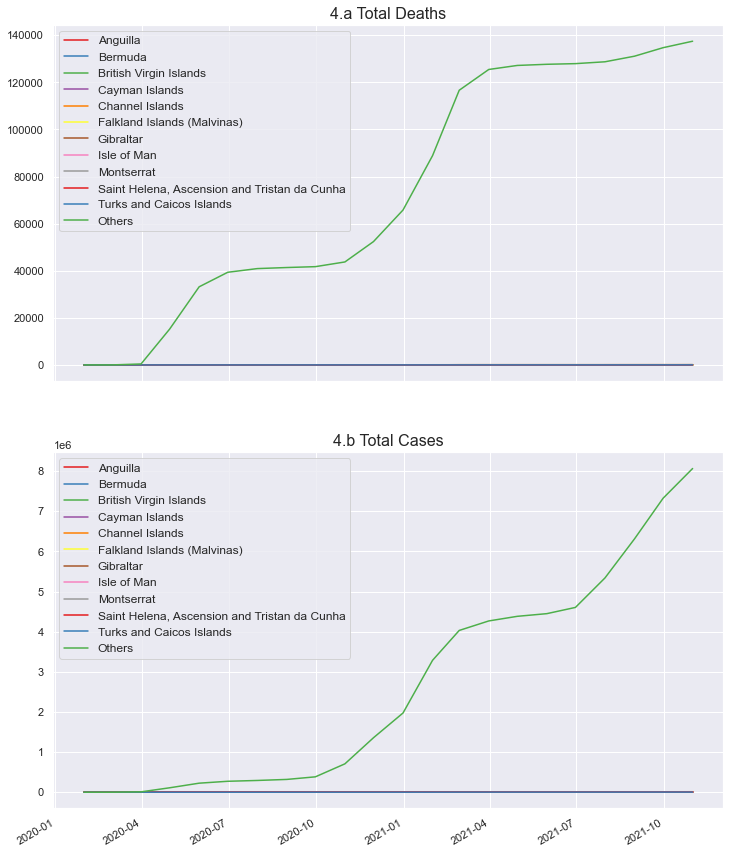

In [276]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(12,16))
plt.rcParams["image.cmap"] = "Dark2"

# Loop the get the provinces names and resample to Month to smooth the chart
for Province in final_table['Province/State'].unique():
    temp_df = final_table[(final_table['Province/State'] == Province)]
    df_smooth = temp_df.resample('M').mean()

# Plots for cases and deaths
    ax2.plot('Cases', data=df_smooth, label=Province)
    ax1.plot('Deaths', data=df_smooth, label=Province)

ax2.legend(loc='upper left', prop={'size': 12})
ax1.legend(loc='upper left', prop={'size': 12})
ax2.set_title("4.b Total Cases", fontsize=16)
ax1.set_title("4.a Total Deaths", fontsize=16)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
fig.autofmt_xdate()

#### Observation:

As we can see from figures 4.a and 4.b the 'Others' province distorts the chart as its values are significantly higher than the remaining provinces. As such, it is difficult to identify any patterns or trends for the smaller provinces.To overcome this I will remove the 'Others' province and replot the values.

I will also group and aggregate the total values of the provinces and create a dataframe with the totals and percentage shares for deaths and cases. 


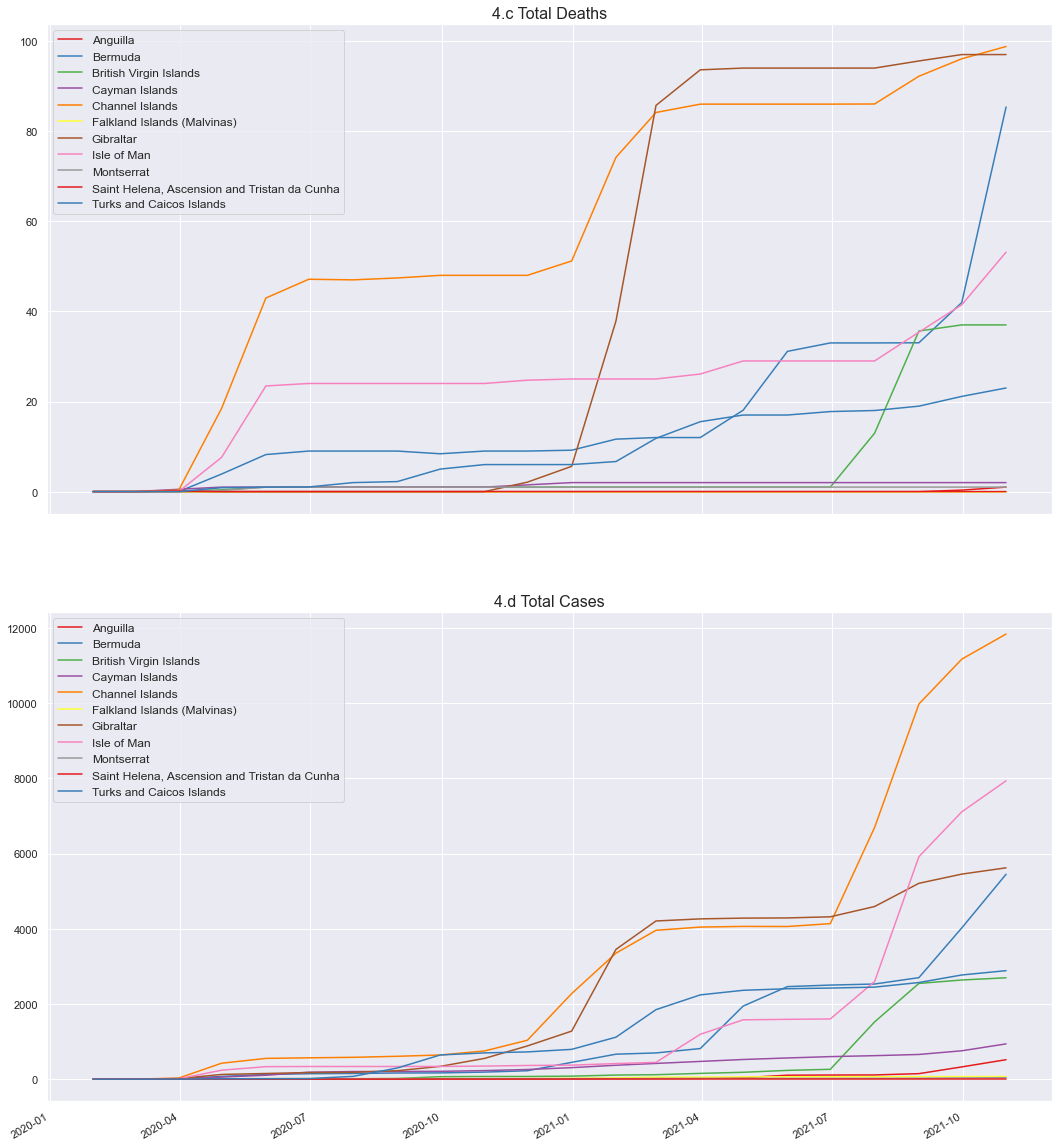

In [277]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,22))
plt.rcParams["image.cmap"] = "Dark2"

# Create df without the 'Others' province
lesser_provinces = final_table[final_table['Province/State'] !='Others']

# Loop the get the provinces names and resample to Month to smooth the chart
for Province in lesser_provinces['Province/State'].unique():
    temp_df = lesser_provinces[(lesser_provinces['Province/State'] == Province)]
    df_smooth = temp_df.resample('M').mean()

# Plots for cases and deaths
    ax2.plot('Cases', data=df_smooth, label=Province)
    ax1.plot('Deaths', data=df_smooth, label=Province)

ax2.legend(loc='upper left', prop={'size': 12})
ax1.legend(loc='upper left', prop={'size': 12})
ax2.set_title("4.d Total Cases", fontsize=16)
ax1.set_title("4.c Total Deaths", fontsize=16)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
fig.autofmt_xdate()

In [258]:
# Group and aggregate total deaths
total_deaths = final_table.groupby(['Province/State'], 
sort=False, as_index=False)['Deaths'].max().sort_values('Deaths',ascending=False)

# Group and aggregate total cases
total_cases = final_table.groupby(['Province/State'], 
sort=False, as_index=False)['Cases'].max().sort_values('Cases',ascending=False)

# Calculate percentage of total deaths 
total_deaths ['% of total deaths'] = (total_deaths['Deaths'] / total_deaths['Deaths'].sum()) * 100

# Calculate percentage of total cases
total_cases['% of total cases'] = (total_cases['Cases'] / total_cases['Cases'].sum()) * 100

# Merge dfs
pd.merge(total_cases, total_deaths[["Province/State", "Deaths", "% of total deaths"]], on="Province/State", how="left")

,Province/State,Cases,% of total cases,Deaths,% of total deaths
0,Others,8317439.0,99.531424,138237.0,99.703566
1,Channel Islands,12135.0,0.145215,100.0,0.072125
2,Isle of Man,8343.0,0.099837,54.0,0.038948
3,Gibraltar,5727.0,0.068533,97.0,0.069961
4,Bermuda,5548.0,0.066391,95.0,0.068519
5,Turks and Caicos Islands,2910.0,0.034823,23.0,0.016589
6,British Virgin Islands,2725.0,0.032609,37.0,0.026686
7,Cayman Islands,1011.0,0.012098,2.0,0.001443
8,Anguilla,644.0,0.007706,1.0,0.000721
9,Falkland Islands (Malvinas),69.0,0.000826,0.0,0.000000


#### Observations

In terms of deaths, from figures 4.c and 4.d, we can see that the curve seems to have plateaued and is flattening only for Gibraltar, Turks and Caicos, and the British Virgin Islands. All of the other provinces are in clear upward trends and do not look like they have peaked yet. 

Of those provinces where deaths do not look to have peaked Bermuda and the Isle of Man have the steepest curve indicating that deaths are increasing at a fast rate.

In terms of positive cases the plot shows that cases in all provinces are in upward trends and we are yet to see a peak anywhere. Although still in an observable upward trend The British Virgin Islands and Turks and Caicos look to be the only provinces close to flattening.

The sharpest upward trends in positive case numbers are Bermuda and 'Others'. Both of these are interesting but for different reasons. Bermuda is a interesting because it has one of the sharpest upward trends in both deaths and cases. On the other hand 'Others' is interesting as thsi province accounts for 99.5% of all cases and 99.7% of all deaths. As such, the sharp upward trend in cases is concerning.
  
The time-series plots above are cumulative values and as such are expected to increase overtime. The insights gained are limited to providing a general picture and is not enough to answer the business question. 

To better answer the business question; which province should be targeted first? We need to know the growth rate of cases across the different regions and compare these both numerically and over time.

To achieve this the following cells will:

a) extract the new daily cases for provinces into a new column in the DataFrame using the .diff() function

b) calculate the growth rate by subtracting total cases from daily cases and multiplying by 100. This will give us a percentage growth.

c) calculate the average National and Province growth rates

d) compare the relative differences and plot on a timeseries.


In [100]:
# a) Create a new cases column in the DataFrame

# create a temp table for the new cases 
temp = final_table.groupby(['Province/State', 'Date', ])[['Cases']]
temp = temp.sum().diff().reset_index()
temp.loc['Cases'] = np.nan

# renaming columns
temp.columns = ['Province/State', 'Date', 'New_cases']

# merging new values
final_table = pd.merge(final_table, temp, on=['Province/State', 'Date'])

# filling na with 0
final_table = final_table.fillna(0)

# fixing data types
cols = ['New_cases']
final_table[cols] = final_table[cols].astype('int')

# loop to replace negative values
final_table['New_cases'] = final_table['New_cases'].apply(lambda x: 0 if x<0 else x)

# b) calculate the growth rate and store in a new column
final_table['Growth_rate'] = (final_table['New_cases'] / final_table['Cases']) *100

# filling na with 0
final_table['Growth_rate'].fillna(0, inplace=True)

# change index to date column
final_table.index = final_table['Date']

#Drop extra date column 
final_table.drop(['Date'], axis = 1, inplace=True)


final_table.head()
print(final_table2.shape)

(7584, 12)


In [146]:
#c) Country and province averages


# Average daily growth rate for the United Kingdom
print(final_table.groupby('Country/Region')['Growth_rate'].aggregate('mean'))

# Average daily growth for each province
final_table.groupby('Province/State')['Growth_rate']\
.aggregate('mean').reset_index().sort_values('Growth_rate', ascending=False)


Country/Region
United Kingdom    1.162568
Name: Growth_rate, dtype: float64


,Province/State,Growth_rate
9,Others,2.318293
4,Channel Islands,1.460100
1,Bermuda,1.422096
7,Isle of Man,1.336811
6,Gibraltar,1.334706
2,British Virgin Islands,1.158451
11,Turks and Caicos Islands,1.147914
3,Cayman Islands,1.110188
0,Anguilla,0.972750
5,Falkland Islands (Malvinas),0.689045


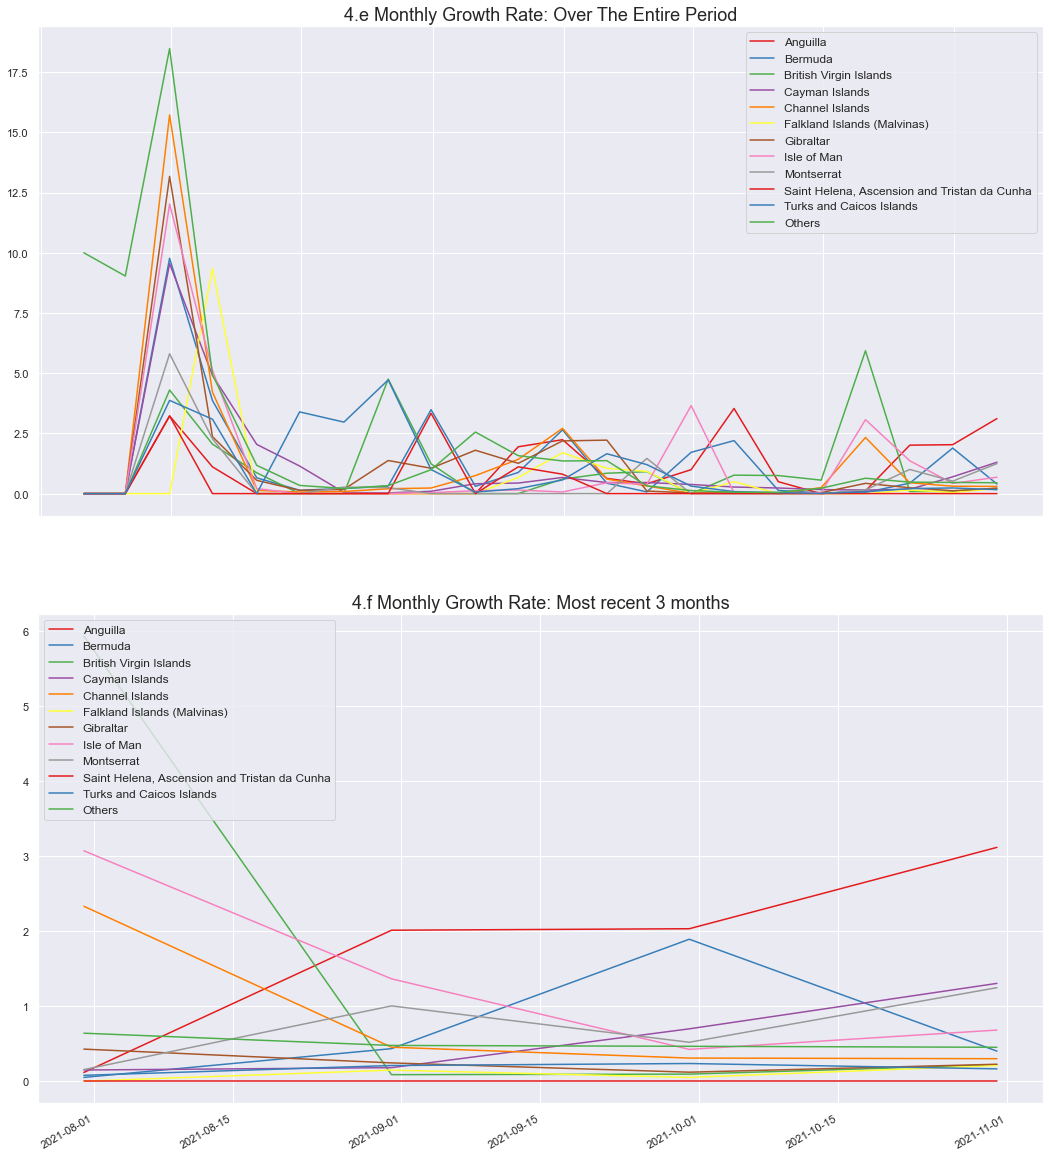

In [278]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,22))
plt.rcParams["image.cmap"] = "Dark2"

# Loop the get the provinces names and resample to Month to visualise Monthly values
for Province in final_table['Province/State'].unique():
    temp_df = final_table[(final_table['Province/State'] == Province)]
    monthly_growth = temp_df.resample('M').mean()

# Plot growth rate for the entire period and the last 3 months
    ax2.plot('Growth_rate', data=monthly_growth[18:23], label=Province)
    ax1.plot('Growth_rate', data=monthly_growth, label=Province)

# Plot asthetics
ax2.legend(loc='upper left', prop={'size': 12})
ax1.legend(loc='upper right', prop={'size': 12})
ax2.set_title("4.f Monthly Growth Rate: Most recent 3 months", fontsize=18)
ax1.set_title("4.e Monthly Growth Rate: Over The Entire Period", fontsize=18)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
fig.autofmt_xdate()

#### Observation

We can see from the aggregated averages that 'Others' has been growing at 2.3% per day throughout the pandemic which is more than double the national average rate.  

In figure 4.e we can see that there is a large peak in growth rate at the start of the pandemic followed by a sharp drop. This is due to the fact that at the start of the pandemic small changes in values result in high percentage growths. If the starting point is 0 then 1 new case represents a 100% growth rate. This also explains why the average growth rate for 'Others' is significantly higher than the national average as it is to be expected that there would be more cases due t its larger population

Figure 4.f represents the most recent 3 months, here we can see that Anguilla's growth is significantly higher than the other provinces. This can be attributed to very small case numbers. 'Others', British Virgin Islands, Channel Islands, Turks and Caicos, and Gibraltar are flat. Whilst Montserrat, Isle of Man and Cayman Islands are increasing.

Interestingly, the growth rate for Bermuda, which has the sharperst upward trends in both toal cases and deaths (as seen in figures 4.c and 4.d), is trending downwards.